# Uncovering foreign aid allocation patterns with Bayesian computation

Kevin Nguyen \
STAT 5630 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wbgapi as wb #World Bank API
import country_converter as coco # convert to ISO3 codes
import pymc3 as pm #for bayesian regression
import arviz as az #for ploting trace plots and posterior dist
import tensorflow as tf
import tensorflow_probability as tfp # for bayesian neural net
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import StandardScaler, OneHotEncoder # to process BNN data
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score 
import seaborn as sns
import matplotlib.pyplot as plt
import os 
import warnings


os.chdir('/Users/kevnguyen/Library/CloudStorage/GoogleDrive-keng2413@colorado.edu/My Drive/STAT 5630/project')
warnings.filterwarnings("ignore")

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


# Data Prep

## Imports

In [2]:
wb_data = wb.data.DataFrame(["SL.UEM.TOTL.ZS","SM.POP.REFG.OR","BX.KLT.DINV.CD.WD","SP.POP.TOTL","SP.DYN.IMRT.IN","NY.GDP.MKTP.CD"], 
                            time = 2020, labels=True)

col_names = {'SL.UEM.TOTL.ZS': 'Unemployment Rate (%)',
        'SM.POP.REFG.OR': 'log_refugee_pop',
        'SP.POP.TOTL': 'log_pop',
        'NY.GDP.MKTP.CD': 'log_GDP',
        'SP.DYN.IMRT.IN': 'Infant Mortality Rate',
        'BX.KLT.DINV.CD.WD': 'log_fdi_net'}
wb_data.rename(columns=col_names,
          inplace=True)
wb_data.reset_index(inplace=True)
wb_data.rename({'economy':'ISO3'}, axis = 1, inplace =True)
wb_data.drop(['Country'],axis =1,inplace =True)
skew = ['log_pop', 'log_refugee_pop', 'log_GDP', 'log_fdi_net']
skewed = wb_data[skew]
wb_data['log_GDP'] = np.log(wb_data['log_GDP']+1)
wb_data['log_pop'] = np.log(wb_data['log_pop']+1)
wb_data['log_fdi_net'] =np.log(wb_data['log_fdi_net']+1)
wb_data['log_refugee_pop'] = np.log(wb_data['log_refugee_pop']+1)

wb_data.head()

,ISO3,log_fdi_net,log_GDP,Unemployment Rate (%),log_refugee_pop,Infant Mortality Rate,log_pop
0,ZWE,18.828543,23.791770,7.898000,9.056723,36.6,16.567237
1,ZMB,19.317607,23.619765,6.030000,5.533389,41.1,16.756138
2,YEM,NaN,NaN,13.575000,10.386963,45.8,17.290084
3,PSE,18.194345,23.466149,25.889999,11.514464,13.2,15.384807
4,VIR,NaN,22.159302,13.255000,NaN,NaN,11.573936


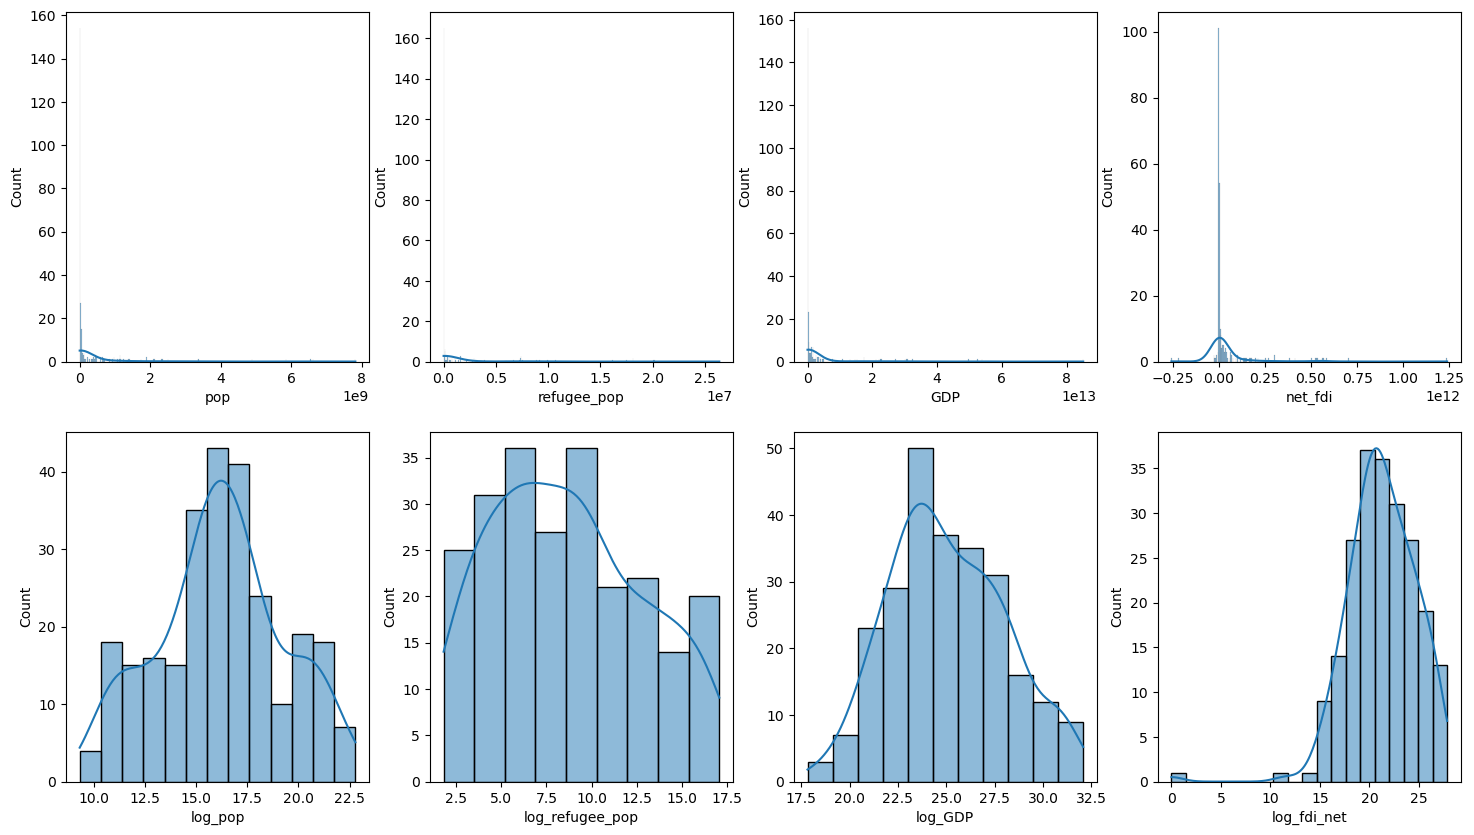

In [3]:
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
skew_labs = ['pop', 'refugee_pop', 'GDP', 'net_fdi']

for i, lab in enumerate(skew):
    ax = sns.histplot(skewed, x = lab, kde = True,ax=axes[0,i])
    ax.set(xlabel=skew_labs[i])
    ax1 = sns.histplot(wb_data, x = lab, kde = True,ax=axes[1,i])
plt.savefig('skew.png', dpi=300)

In [4]:
#Freedom House Civil Liberties and Political Rights score
freedom = pd.read_excel("data/Country_and_Territory_Ratings_and_Statuses_FIW_1973-2022 .xlsx", 
                           skiprows=2, sheet_name=1, na_values = '-', usecols = 'A, EM:EO')
freedom_cols = ['Country', 'FH Political Rights Score', 'FH Civil Liberties Score', 'FH Status'] #rename columns
freedom.columns = freedom_cols
freedom['ISO3'] = coco.convert(names=freedom['Country'], to='ISO3')
freedom.drop(['Country', 'FH Status'],axis=1,inplace =True)
freedom = freedom[freedom['FH Political Rights Score'].notna() & freedom['FH Civil Liberties Score'].notna()]
freedom.head()

Germany, E.  not found in regex
Germany, W.  not found in regex
Serbia and Montenegro not found in regex
USSR not found in regex
Vietnam, N. not found in regex
Vietnam, S. not found in regex
Yugoslavia not found in regex


,FH Political Rights Score,FH Civil Liberties Score,ISO3
0,5.0,6.0,AFG
1,3.0,3.0,ALB
2,6.0,5.0,DZA
3,1.0,1.0,AND
4,6.0,5.0,AGO


In [5]:
corruption = pd.read_excel('data/CPI2021_GlobalResults&Trends.xlsx',
                          skiprows = 2, usecols ='A,B,D')
corruption.drop(['Country / Territory'], inplace =True, axis = 1)
corruption.head()

,ISO3,CPI score 2021
0,DNK,88
1,FIN,88
2,NZL,88
3,NOR,85
4,SGP,85


In [6]:
#Foreign aid data
aid = pd.read_csv('data/us_foreign_aid_country.csv')
# Drop trailing letters from Fiscal Year column and convert to integer
aid['Fiscal Year'] = aid['Fiscal Year'].str.replace(r'\D+', '', regex=True).astype('int')

# Only include 2020 data and drop unneccessary columns
aid_new = aid[aid['Fiscal Year'] == 2020].pivot(index='Country Code', 
                                                columns='Transaction Type Name', 
                                                values='current_amount')
aid_new.reset_index(inplace =True)
aid_new.rename({'Country Code': 'ISO3'}, axis = 1, inplace =True)
aid_new = aid_new[['ISO3', 'Disbursements']].dropna()
aid_new['log_disbursements'] = np.log(abs(aid_new['Disbursements'])+1)
aid_new.drop(['Disbursements'], axis =1, inplace = True)

aid_new.head()

Transaction Type Name,ISO3,log_disbursements
1,AFG,22.039201
2,AGO,17.383569
3,AIA,10.368416
4,ALB,17.756568
5,ANS,14.405864


In [7]:
politics = pd.read_csv('data/vdem_row_final.csv')
pol_cols = {'country_name': 'country', 
            'year': 'year',
            'electdem_vdem_owid': 'electoral_dem', 
            'freeexpr_vdem_owid': 'free_speech', 
            'suffr_vdem_owid': 'pct_sufferage', 
            'equal_rights_vdem_owid': 'equal_rights',
            'equal_res_vdem_owid':'equal_resources',
            'terr_contr_vdem_owid': 'pct_state_territory',
            'locelect_vdem_owid': 'local_govt_elections'
           }
scores = ['electoral_dem','free_speech','equal_rights','equal_resources','local_govt_elections']
politics1 = politics[[c for c in politics.columns if c in pol_cols]].loc[politics['year'] == 2020]
politics1.rename(columns=pol_cols, inplace =True)
politics1[scores]= politics1[scores].multiply(100, axis="index")
politics1['ISO3'] = coco.convert(names=politics1['country'], to='ISO3')
politics1.drop(['country', 'year'], axis = 1, inplace = True)
politics1=politics1.loc[politics1['ISO3'] != 'not found']

politics1.head()

Africa not found in regex
Asia not found in regex
Europe not found in regex
North America not found in regex
Oceania not found in regex
South America not found in regex
Timor not found in regex
World not found in regex
Zanzibar not found in regex


,electoral_dem,free_speech,pct_sufferage,local_govt_elections,equal_rights,equal_resources,pct_state_territory,ISO3
231,35.6,74.2,100.0,0.5,51.3,26.9,43.667,AFG
576,49.3,67.1,100.0,90.5,68.6,73.2,95.667,ALB
699,27.9,54.1,100.0,5.6,75.2,71.3,97.333,DZA
822,34.9,63.1,100.0,NaN,9.8,21.5,90.833,AGO
1056,82.2,91.2,100.0,91.2,67.3,69.1,99.167,ARG


## Merging

In [8]:
## merge datasets
df = wb_data.merge(freedom, how = 'inner', on='ISO3').merge(corruption,how = 'left', on='ISO3').merge(aid_new, how = 'inner', on = 'ISO3').merge(politics1, how = 'left', on = 'ISO3')
df.set_index('ISO3', inplace = True)
df.head()

,log_fdi_net,log_GDP,Unemployment Rate (%),log_refugee_pop,Infant Mortality Rate,log_pop,FH Political Rights Score,FH Civil Liberties Score,CPI score 2021,log_disbursements,electoral_dem,free_speech,pct_sufferage,local_govt_elections,equal_rights,equal_resources,pct_state_territory
ISO3,,,,,,,,,,,,,,,,,
ZWE,18.828543,23.791770,7.898,9.056723,36.6,16.567237,6.0,5.0,23.0,19.442956,29.3,45.4,100.0,80.7,76.9,45.2,100.000
ZMB,19.317607,23.619765,6.030,5.533389,41.1,16.756138,4.0,4.0,33.0,19.740669,33.4,63.9,100.0,52.1,27.6,25.4,99.000
YEM,NaN,NaN,13.575,10.386963,45.8,17.290084,7.0,6.0,16.0,20.202218,11.3,15.3,100.0,2.6,4.8,2.2,52.222
VNM,23.483276,26.571483,2.100,12.665802,16.6,18.386593,7.0,6.0,39.0,19.182537,15.0,13.7,100.0,91.0,57.4,81.8,98.200
VEN,NaN,NaN,7.530,12.050079,21.1,17.165080,7.0,6.0,14.0,18.134066,21.2,28.9,100.0,82.3,41.3,6.3,87.429


## Cleaning

In [9]:
# Create new 'Aid Level' column
def applyFunc(s):
    if s <= df['log_disbursements'].quantile(0.5):
        return 'Low Aid'
    # elif s < df['log_disbursements'].quantile(0.5):
    #     return 'High Aid'
    else:
        return 'High Aid'
df['Aid Level'] = df['log_disbursements'].apply(applyFunc)

In [10]:
#replace with group median
for i in df.columns:
    if pd.api.types.is_numeric_dtype(df[i]):
        df[i].fillna(df.groupby('Aid Level')[i].transform('median'), inplace = True) # replace with group median (quantitative)
df.head()
df.to_csv('foreign_aid.csv')

In [11]:
df_numeric = df.select_dtypes(include='number') # for bayesian regression
X=df_numeric.drop(['log_disbursements'], axis = 1) 
X.insert(0,'intercept',1) # add intercept column to design matrix
y = df['log_disbursements'] #response

In [12]:
X_new = df_numeric.drop(['log_disbursements'], axis = 1)

# EDA

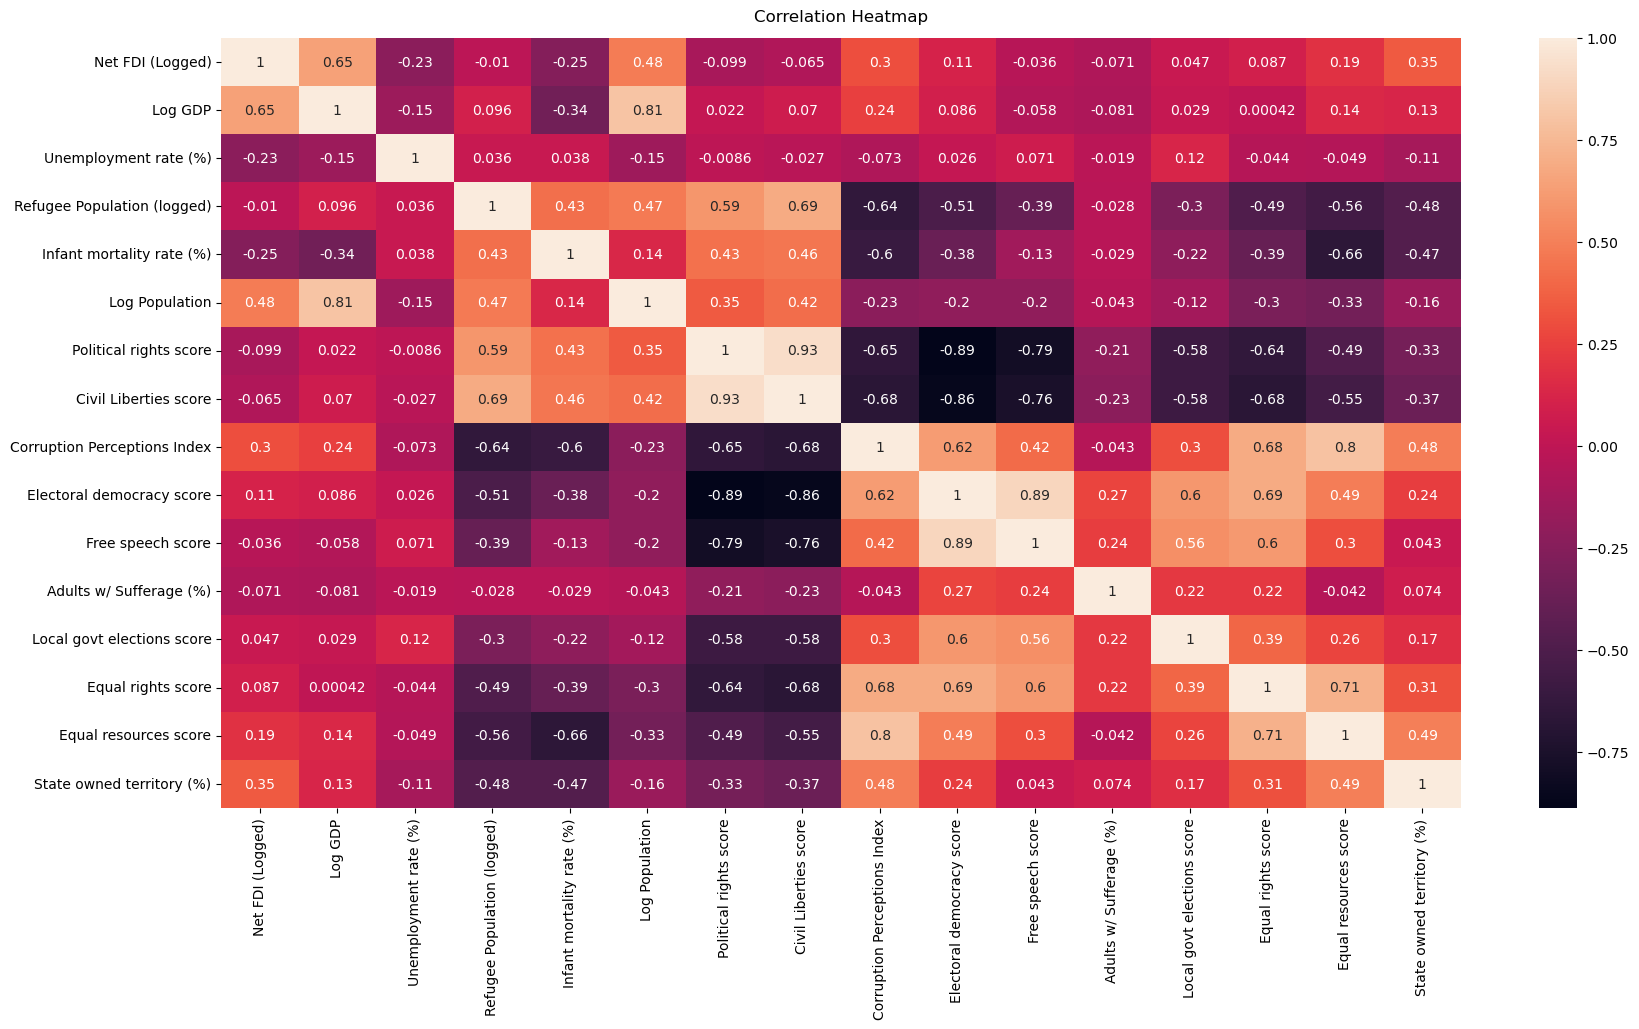

In [13]:
labs = ['Net FDI (Logged)', 
        'Log GDP', 
        'Unemployment rate (%)', 
        'Refugee Population (logged)', 
        'Infant mortality rate (%)', 
        'Log Population', 
        'Political rights score', 'Civil Liberties score',
        'Corruption Perceptions Index', 
        'Electoral democracy score', 
        'Free speech score', 
        'Adults w/ Sufferage (%)', 
        'Local govt elections score',
        'Equal rights score',
        'Equal resources score',
        'State owned territory (%)'
       ]
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(X_new.corr(),annot=True, xticklabels=labs, yticklabels=labs)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()

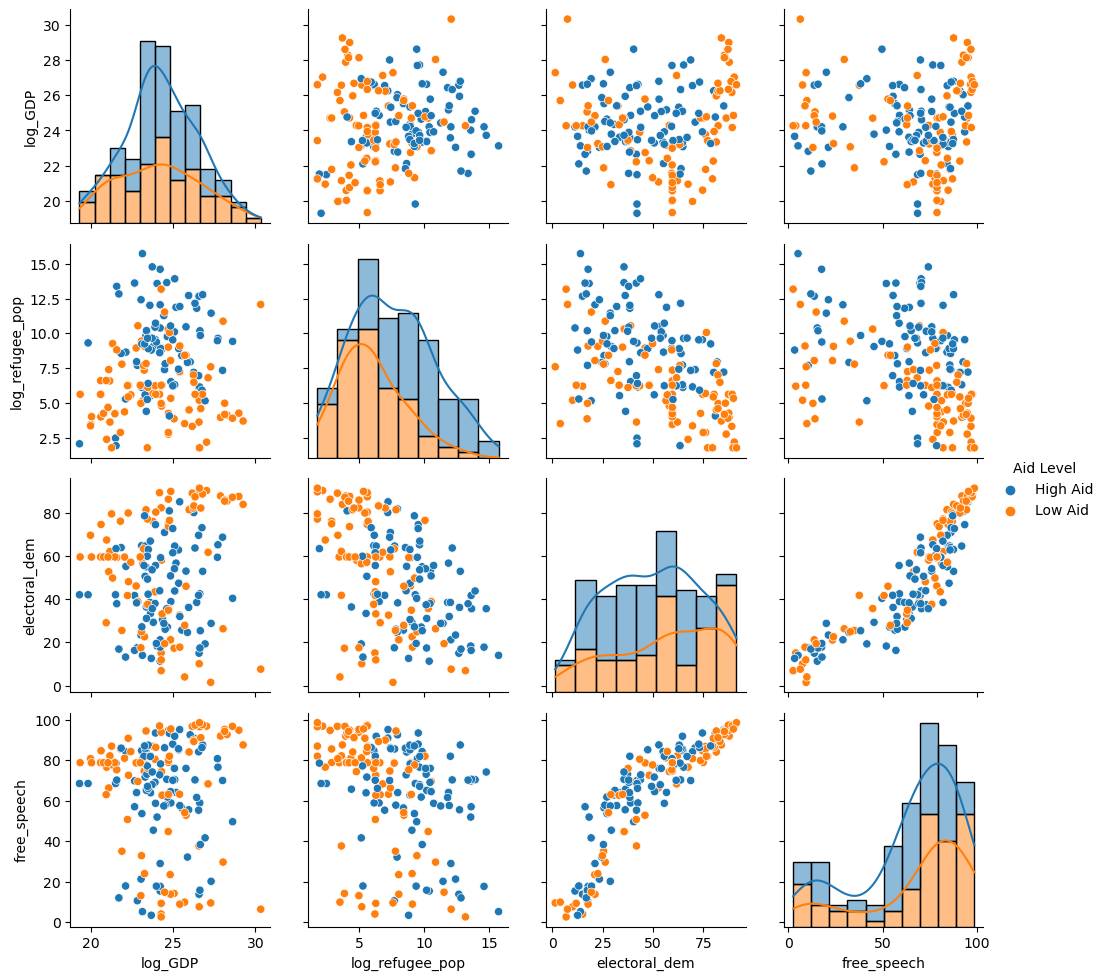

In [14]:
df_plot = df[['log_GDP', 'log_refugee_pop', 'electoral_dem', 'free_speech', 'Aid Level']]

g = sns.PairGrid(df_plot, hue = 'Aid Level')
g.map_diag(sns.histplot, multiple = 'stack', kde =True)
g.map_offdiag(sns.scatterplot, data = df_plot)
g.add_legend()
plt.savefig('pairs.png', dpi=300)
plt.show()

# Bayesian Regression with PyMC

In [52]:
with pm.Model() as model:
    #uninformative priors
    beta = pm.Normal('beta', mu = 0, sd = 100, shape = X.shape[1]) 
    sigma = pm.InverseGamma('sigma', alpha=1,beta=1)
    
    y_pred = pm.Normal('y_pred', mu=pm.math.dot(X,beta), sd=sigma, observed=y)
    idata = pm.sample(2000, cores=1) #No U-Turn Sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 24 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


In [53]:
az.summary(idata) #2, 4, 6, 10, 11

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],15.522,4.078,7.893,23.170,0.096,0.068,1805.0,2246.0,1.0
beta[1],0.047,0.091,-0.129,0.211,0.002,0.001,3456.0,2954.0,1.0
beta[2],-0.690,0.274,-1.192,-0.165,0.007,0.005,1671.0,2091.0,1.0
beta[3],0.030,0.031,-0.031,0.087,0.000,0.000,5048.0,2901.0,1.0
beta[4],0.250,0.091,0.077,0.421,0.002,0.001,3601.0,2884.0,1.0
beta[5],-0.020,0.016,-0.049,0.009,0.000,0.000,2453.0,2594.0,1.0
beta[6],1.013,0.293,0.437,1.534,0.007,0.005,1868.0,2556.0,1.0
beta[7],-0.253,0.252,-0.736,0.205,0.006,0.004,1995.0,2425.0,1.0
beta[8],-0.013,0.316,-0.622,0.576,0.006,0.005,2399.0,2223.0,1.0
beta[9],-0.040,0.023,-0.081,0.006,0.000,0.000,3086.0,3018.0,1.0


In [69]:
X.iloc[:,10]

ISO3
ZWE    29.30
ZMB    33.40
YEM    11.30
VNM    15.00
VEN    21.20
       ...  
ATG    59.55
AGO    34.90
DZA    27.90
ALB    49.30
AFG    35.60
Name: electoral_dem, Length: 174, dtype: float64

In [77]:
np.linalg.inv(X.T@X)@X.T@y #frequentist estimates

0     15.602164
1      0.045467
2     -0.693771
3      0.029162
4      0.249835
5     -0.020699
6      1.018618
7     -0.256453
8     -0.008929
9     -0.039305
10    -0.054979
11     0.038854
12     0.010501
13     0.003029
14    -0.011048
15    -0.001768
16     0.017415
dtype: float64

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


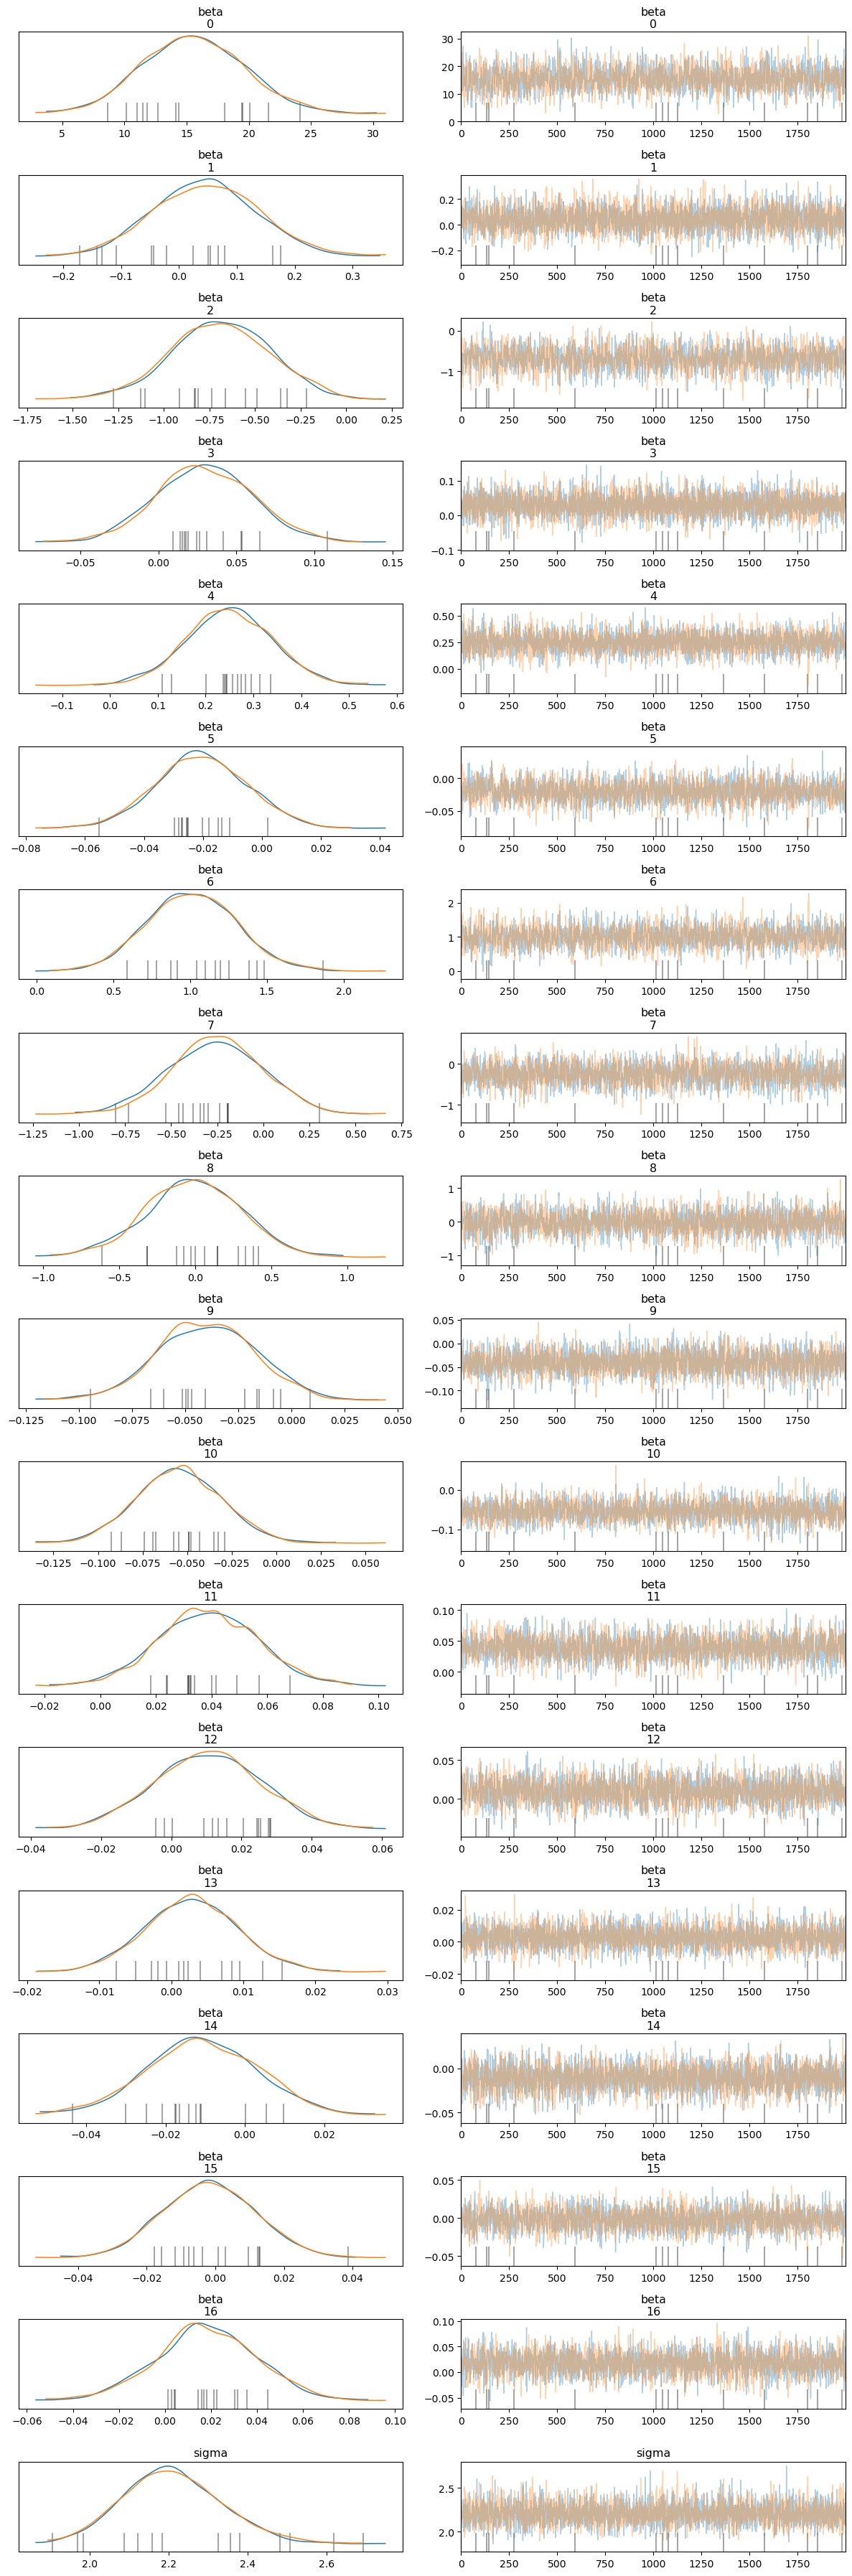

In [54]:
az.plot_trace(idata, compact = False)
plt.tight_layout()
plt.savefig('chains.png', dpi = 300)
plt.show()

# Bayesian Neural Network with tensorflow-probability (Classification)

In [20]:
X_nn = StandardScaler().fit_transform(df.drop(['Aid Level'], axis = 1))
X_nn

array([[-0.53403361, -0.21481649, -0.07941506, ...,  0.65552835,
        -0.41906069,  0.83814627],
       [-0.35300106, -0.29394634, -0.40821468, ..., -1.42646406,
        -1.12560267,  0.74309342],
       [ 0.04310133, -0.02406943,  0.91983332, ..., -2.38933276,
        -1.95347004, -3.70328887],
       ...,
       [ 0.21709077,  0.66308323,  0.68625885, ...,  0.58373551,
         0.5122901 ,  0.58464032],
       [ 0.19227547, -0.37661462,  0.8304168 , ...,  0.30501036,
         0.58008959,  0.42628227],
       [-1.44106975, -0.24500697,  0.5915617 , ..., -0.42558738,
        -1.07207676, -4.51646601]])

In [21]:
y_nn = OneHotEncoder(sparse_output = False).fit_transform(df['Aid Level'].values.reshape(-1,1))
y_nn[0:5,:]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [73]:
X_train, X_test, y_train, y_test= train_test_split(X_nn, y_nn)

In [78]:
# Prior distributed as a multivariate Normal
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag= 100 * tf.ones(n)))]
    )
    return prior_model

# Define variational posterior weight distribution as multivariate Normal
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential([tfp.layers.VariableLayer(tfp.layers.MultivariateNormalTriL.params_size(n), 
                                                                 dtype=dtype),
                                        tfp.layers.MultivariateNormalTriL(n),])
    return posterior_model

numInputs = X_nn.shape[1]
train_size = X_train.shape[0]
numOutputs = y_nn.shape[1]


# Deterministic BNN
hidden_units = [24, 12, 6]
inputs = keras.layers.Input(shape=(numInputs))
features = keras.layers.BatchNormalization()(inputs)

# Create hidden layers with weight uncertainty using the DenseVariational layer.
for units in hidden_units:
    features = tfp.layers.DenseVariational(
        units=units,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        kl_weight=1 / train_size,
        activation="relu",
    )(features)

# The output is deterministic: a single point estimate.
outputs = layers.Dense(units=numOutputs, activation = "softmax")(features)
bnn = keras.Model(inputs=inputs, outputs=outputs)

bnn.summary()

bnn.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 17)]              0         
                                                                 
 batch_normalization_3 (Batc  (None, 17)               68        
 hNormalization)                                                 
                                                                 
 dense_variational_9 (DenseV  (None, 24)               93960     
 ariational)                                                     
                                                                 
 dense_variational_10 (Dense  (None, 12)               45450     
 Variational)                                                    
                                                                 
 dense_variational_11 (Dense  (None, 6)                3159      
 Variational)                                              

2/2 [==============================] - 0s 20ms/step
Accuracy score: 0.84


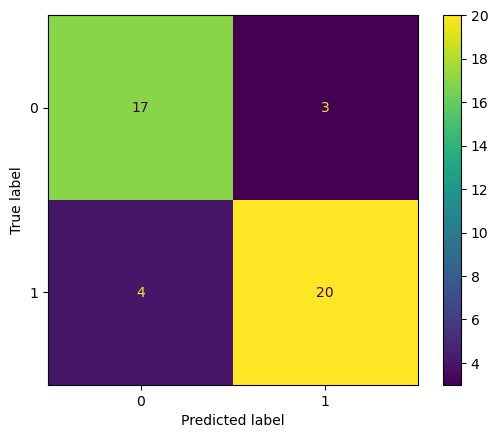

In [81]:
hist_bnn = bnn.fit(X_train, y_train, epochs = 2000, batch_size = 32, validation_split = 0.25, verbose = False)
y_pred_probs = bnn.predict(X_test) # returns prediction outputs as probabilities
y_hat= np.argmax(y_pred_probs,axis =1)
y_true= np.argmax(y_test, axis = 1)
ConfusionMatrixDisplay(confusion_matrix(y_hat, y_true)).plot()
print('Accuracy score:', round(accuracy_score(y_hat, y_true),2))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_8 (Batc  (None, 17)               68        
 hNormalization)                                                 
                                                                 
 dense_28 (Dense)            (None, 24)                432       
                                                                 
 dense_29 (Dense)            (None, 12)                300       
                                                                 
 dense_30 (Dense)            (None, 6)                 78        
                                                                 
 dense_31 (Dense)            (None, 2)                 14        
                                                                 
Total params: 892
Trainable params: 858
Non-trainable params: 34
_______________________________________________________

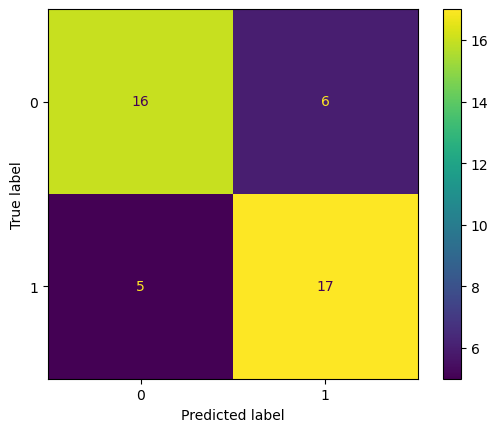

In [89]:
mod_ann = keras.models.Sequential([
    layers.BatchNormalization(input_dim = numInputs),
    layers.Dense(24,activation = "relu"),
    layers.Dense(12,activation = "relu"),
    layers.Dense(6, activation = 'relu'),
    layers.Dense(2, activation = 'softmax')]
)
mod_ann.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
mod_ann.summary()

hist = mod_ann.fit(X_train, y_train, epochs = 2000, batch_size = 32, validation_split = 0.25, verbose = False)

y_pred_ann= mod_ann.predict(X_test) 
y_hat_ann= np.argmax(y_pred_ann,axis =1)

ConfusionMatrixDisplay(confusion_matrix(y_hat_ann, y_true)).plot()
print('Accuracy score:', round(accuracy_score(y_hat_ann, y_true),2))